In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

## Monthly 90th Percentile Max Lead by ZIP Code (Grouped by Calendar Month)

### 🧪 Monthly 90th Percentile Max Lead Levels by ZIP Code

### 🔍 Objective
This analysis maps out lead contamination in Chicago water samples by identifying the 90th percentile of lead levels across ZIP codes and calendar months. Focusing on the 90th percentile helps isolate extreme contamination cases — the most dangerous readings that are often hidden in average values — offering a clearer picture of where the worst risks are concentrated.

---

### 🗂️ Data Sources
Two main data sources were used:
- Water testing data containing sample dates, ZIP codes, and lead levels.
- A public dataset of Chicago ZIP code boundaries, which allows for geospatial visualization.

---

### 🧹 Data Cleaning & Preparation
The data was cleaned by standardizing ZIP codes, parsing sample dates, removing missing values, and ensuring numerical consistency. Each sample was tagged with its calendar month, allowing us to break down lead trends across the year.

---

### 📊 Metric: 90th Percentile Lead Level
For each ZIP code and each calendar month, the 90th percentile of maximum lead levels was calculated. This percentile was chosen to highlight severe cases rather than general averages. It reflects the highest-exposure households in a given area — the communities at the most urgent risk.

---

### 🌍 Spatial Mapping
The processed lead data was merged with geographic ZIP code boundaries. This made it possible to visually map contamination levels across Chicago neighborhoods. A separate map was generated for each month, showing how lead contamination evolves over time.

Each map uses a red color gradient:
- Dark red areas represent ZIP codes with very high 90th percentile lead levels.
- Gray areas indicate ZIP codes with no data for that month.

---

### 🧠 Interpretation & Insights
The monthly maps allow us to:
- Identify persistent hotspots — ZIP codes with dangerously high readings across many months.
- Detect seasonal spikes — months when contamination rises due to environmental or infrastructure-related factors.
- Compare neighborhoods and track geographic disparities in exposure.

---

### 🦇 How This Helps Save Gotham (a.k.a. Chicago)
This visualization can guide:
- Public health interventions like distributing filters or issuing warnings.
- Policy decisions on replacing old lead service lines or prioritizing inspections.
- Community outreach and education in the most at-risk neighborhoods.

By turning raw lead test data into actionable insight, this project supports smarter, faster, and fairer environmental health decisions — which, in turn, protect the city’s most vulnerable residents.

---

### ✅ Summary
- The project transforms monthly water test data into ZIP-level lead exposure maps.
- It highlights where and when extreme contamination occurs.
- It equips policymakers and public health officials with critical tools to take targeted action.



In [11]:
import geopandas as gpd

# Load Chicago ZIP Code boundaries from public data source (City of Chicago Data Portal)
zip_url = "https://data.cityofchicago.org/api/geospatial/unjd-c2ca?method=export&format=GeoJSON"
gdf = gpd.read_file(zip_url)

# Preview the data
gdf.head()


,objectid,zip,shape_area,shape_len,geometry
0,33,60647,106052287.488,42720.0444058,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ..."
1,34,60639,127476050.762,48103.7827213,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ..."
2,35,60707,45069038.4783,27288.6096123,"MULTIPOLYGON (((-87.785 41.90915, -87.78531 41..."
3,36,60622,70853834.3797,42527.9896789,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
4,37,60651,99039621.2518,47970.1401531,"MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ..."


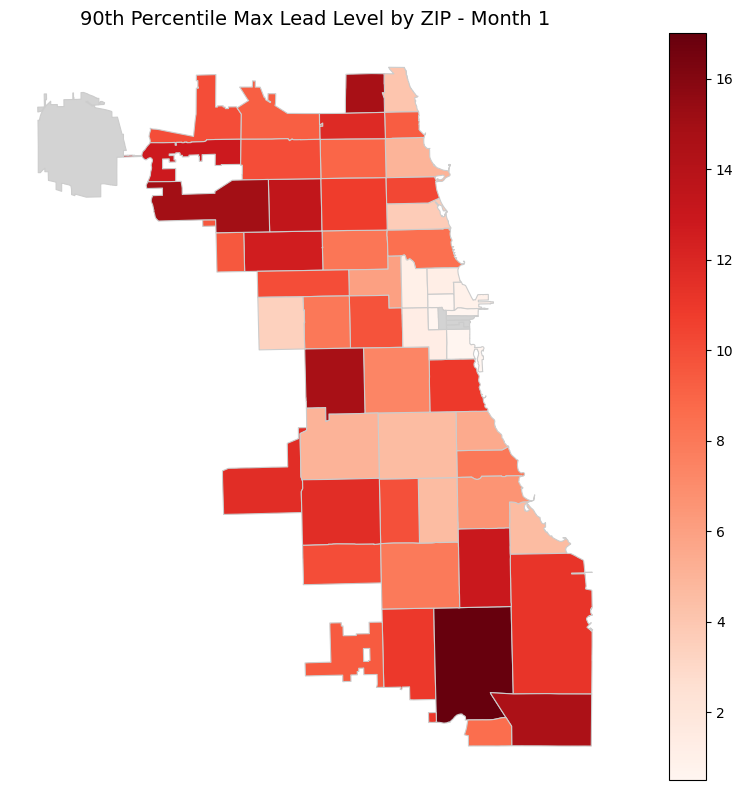

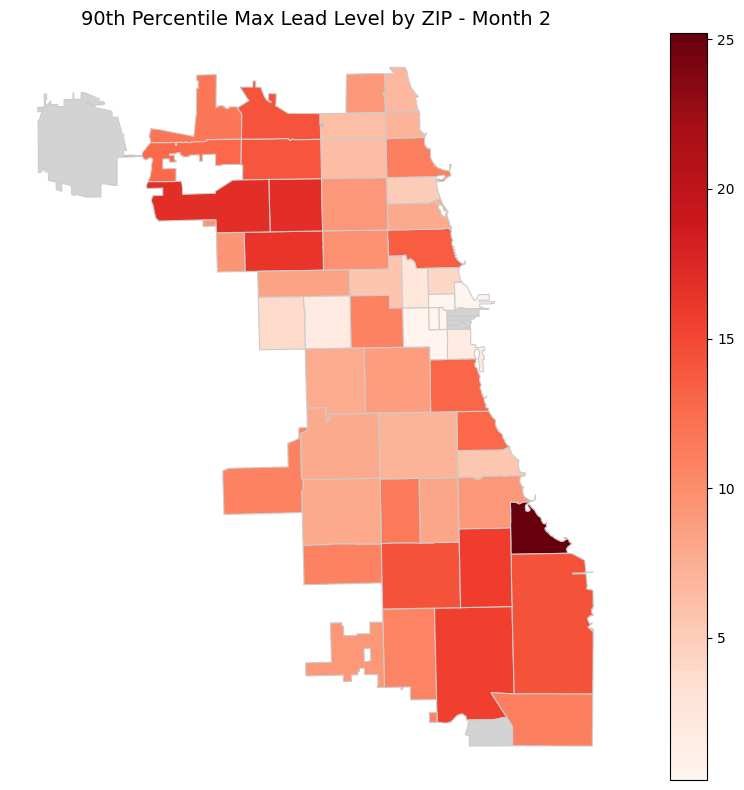

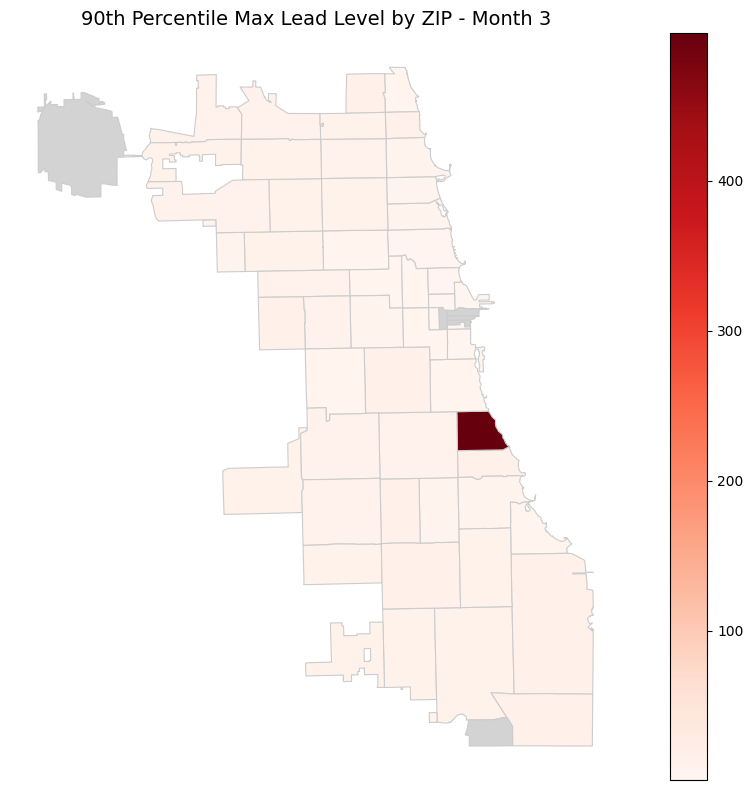

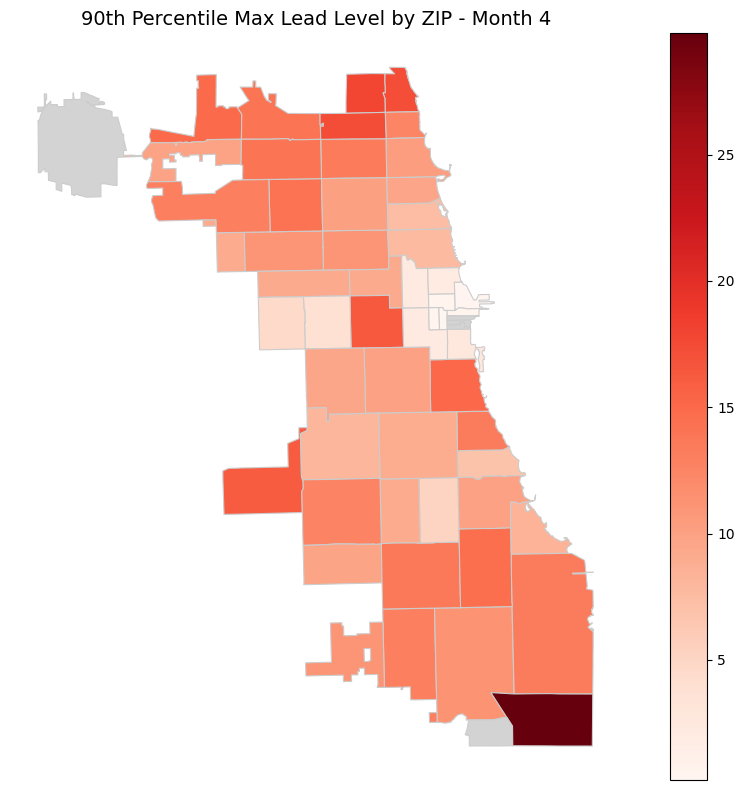

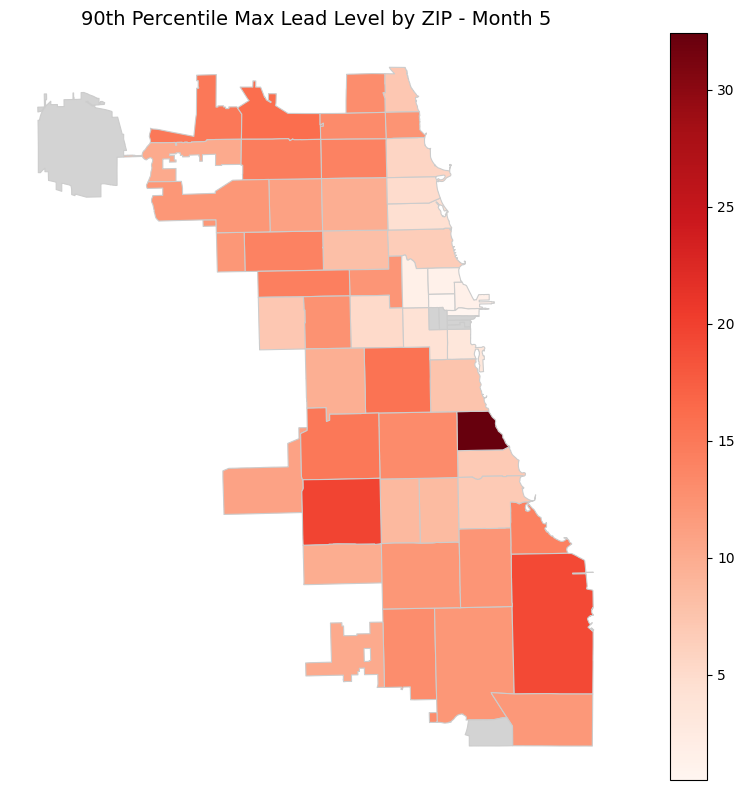

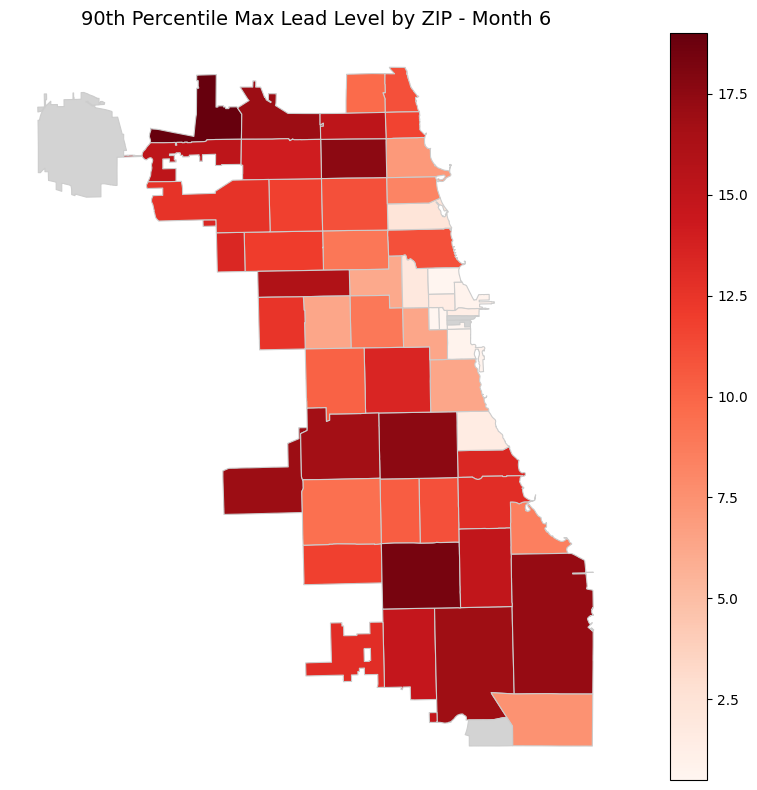

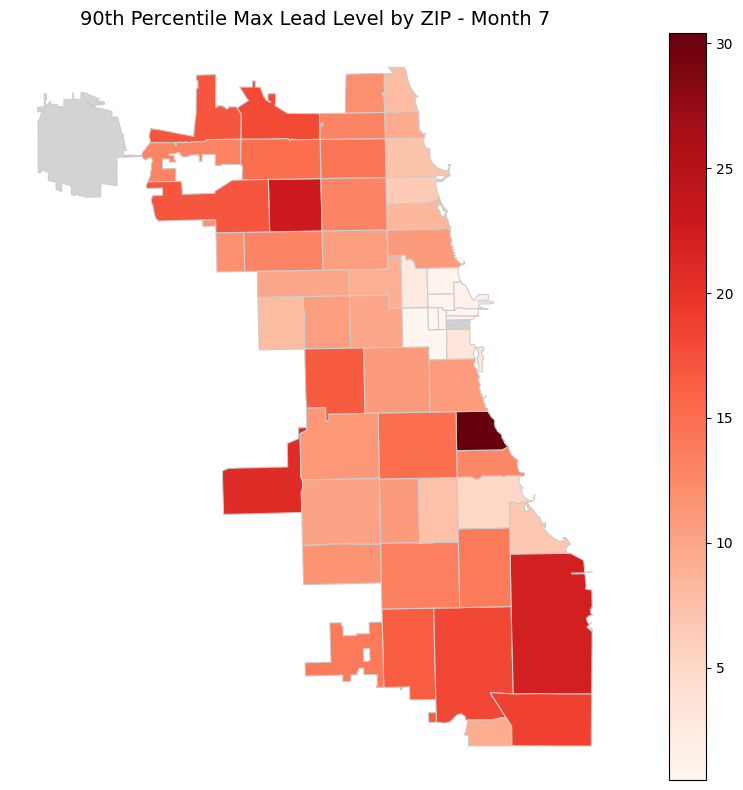

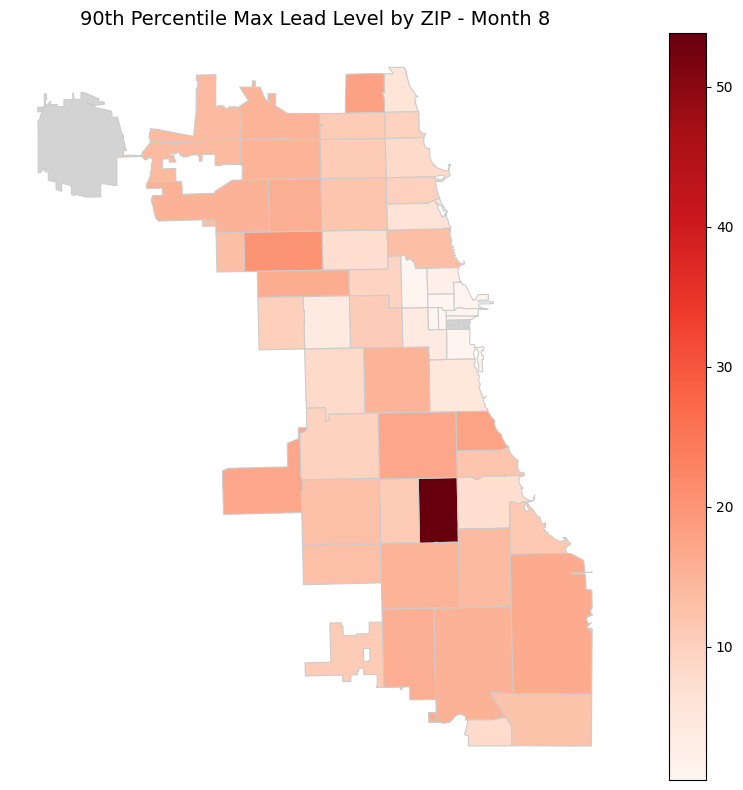

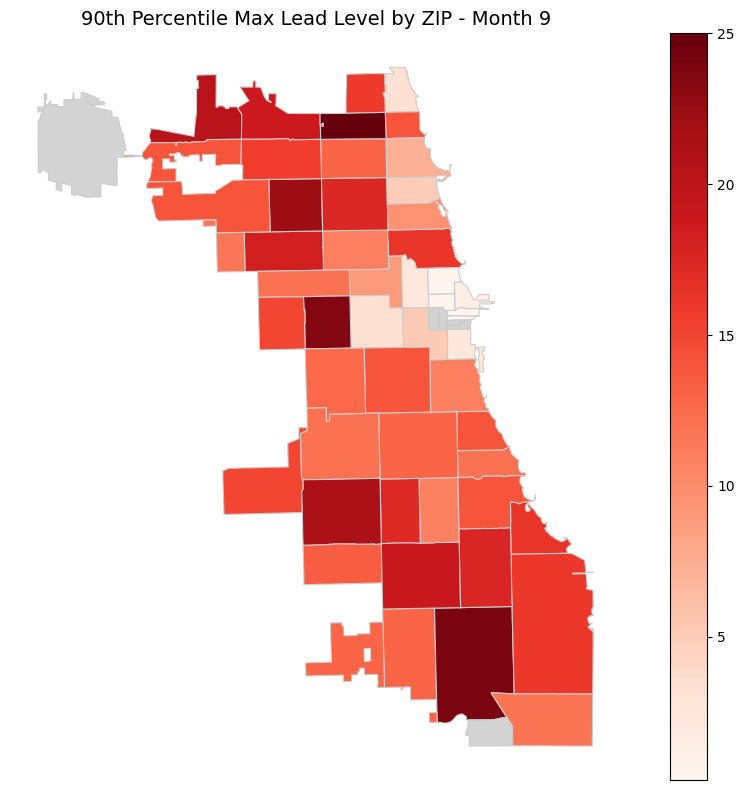

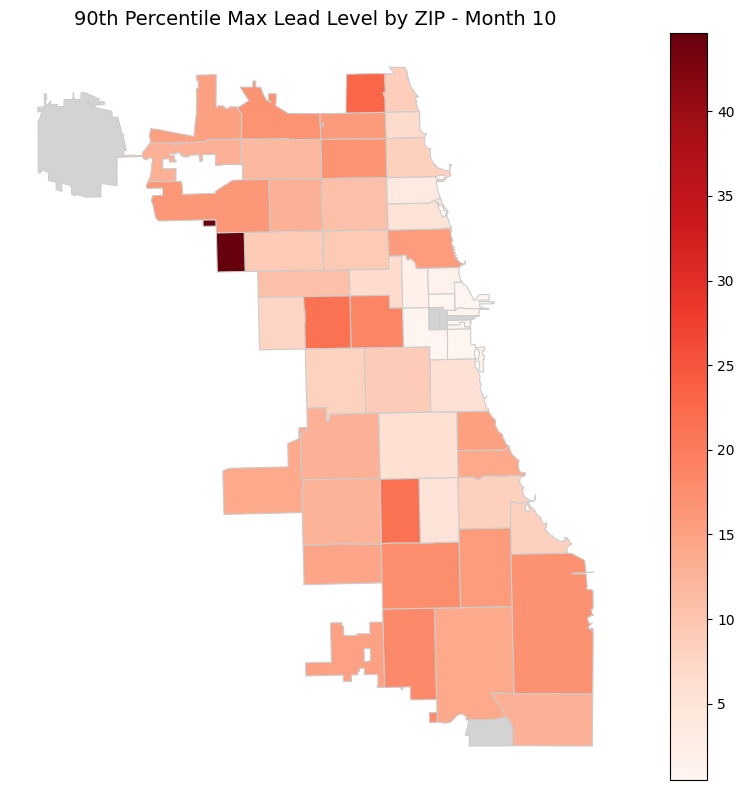

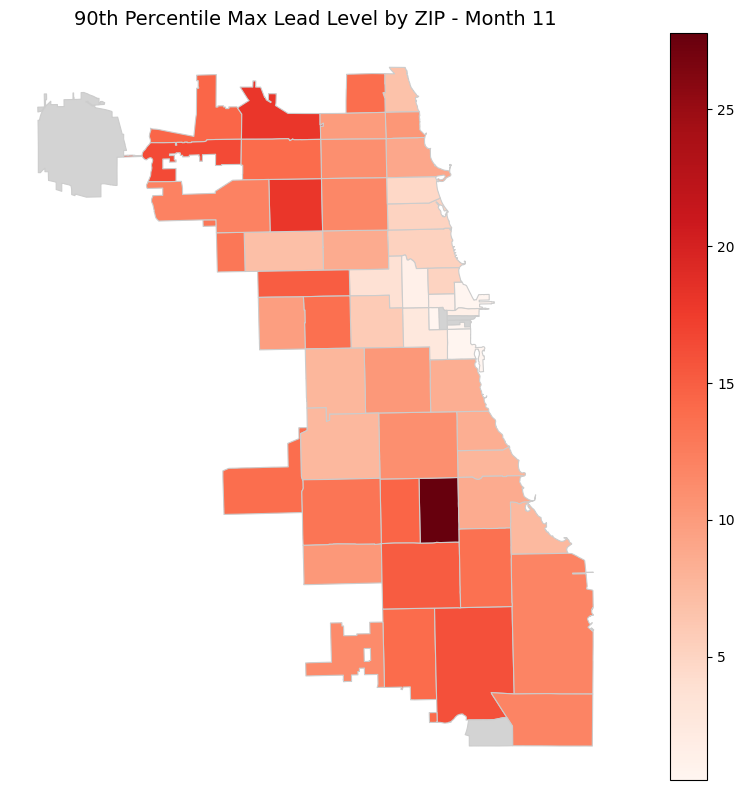

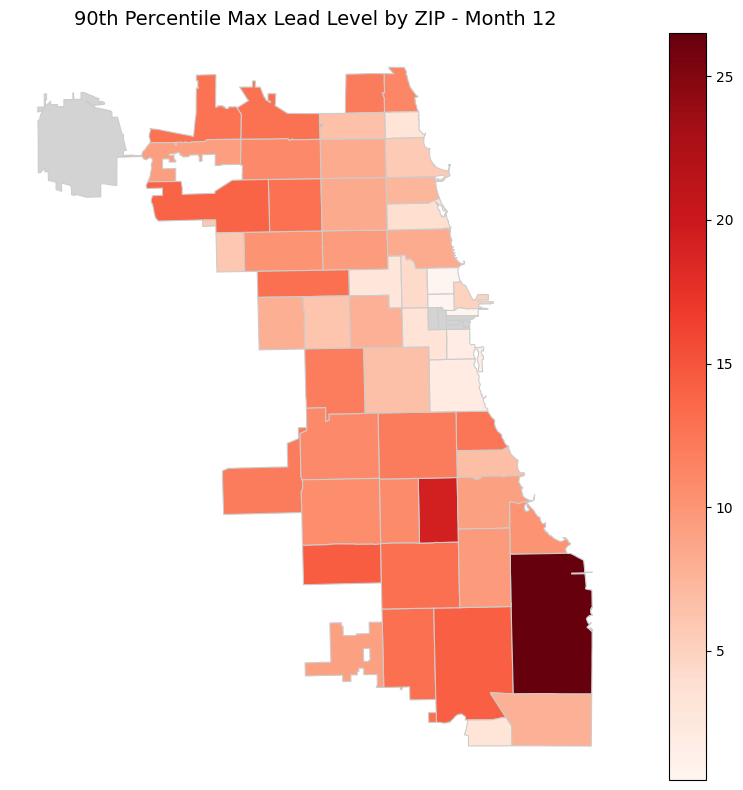

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv')

# Convert Sample Date
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')
df = df.dropna(subset=['Sample Date'])

# Clean ZIP codes (extract 5-digit)
df['ZIP'] = df['property_zip'].astype(str).str.extract(r'(\d{5})')

# Extract month
df['Month'] = df['Sample Date'].dt.month

# Convert 'Max' to numeric
df['Max'] = pd.to_numeric(df['Max'], errors='coerce')

# Drop NaNs in ZIP or Max
df = df.dropna(subset=['ZIP', 'Max'])

# Calculate 90th percentile lead level for each ZIP and month
monthly_90th_by_zip = df.groupby(['ZIP', 'Month'])['Max'].quantile(0.9).reset_index()
monthly_90th_by_zip.columns = ['ZIP', 'Month', 'Lead90']

# Optional: Load ZIP shapefile for Chicago
# Replace with correct path to your shapefile
# Load Chicago ZIP boundaries from City of Chicago's Data Portal
zip_url = "https://data.cityofchicago.org/api/geospatial/unjd-c2ca?method=export&format=GeoJSON"
gdf = gpd.read_file(zip_url)


# Standardize ZIP column name
gdf['ZIP'] = gdf['zip'].astype(str).str.zfill(5)


# Ensure ZIP columns match format
gdf['ZIP'] = gdf['ZIP'].astype(str).str.zfill(5)

# Plot maps for each month
for month in range(1, 13):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge monthly data with GeoDataFrame
    month_data = monthly_90th_by_zip[monthly_90th_by_zip['Month'] == month]
    merged = gdf.merge(month_data, on='ZIP', how='left')

    # Plot
    merged.plot(column='Lead90',
                cmap='Reds',
                linewidth=0.8,
                edgecolor='0.8',
                legend=True,
                ax=ax,
                missing_kwds={"color": "lightgrey", "label": "No data"})

    ax.set_title(f"90th Percentile Max Lead Level by ZIP - Month {month}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

## Seasonal Risk Score by ZIP Code

### Goal
To measure how much more severe lead contamination is during warm months (May–Sep) compared to cold months (Oct–Apr), for each ZIP code.

### What the Code Does
- **Tags each sample** as either "Warm" or "Cold" season based on its month.
- **Groups data by ZIP and season**, calculating the 90th percentile lead level (`Max`) for both warm and cold periods.
- **Calculates a Risk Score** by dividing warm season levels by cold season levels:
  - A score >1 means higher lead levels in warmer months.
- **Sorts and lists the top 15 ZIP codes** with the highest seasonal sensitivity.
- **Maps the scores geographically**, with redder areas showing stronger seasonal effects.

### Output
A ranked table of sensitive ZIPs and a color-coded map showing seasonal vulnerability.


In [13]:
# Define warm (May–Sep) and cold (Oct–Apr) months
warm_months = [5, 6, 7, 8, 9]
cold_months = [1, 2, 3, 4, 10, 11, 12]

# Tag seasons
df['Season'] = df['Month'].apply(lambda x: 'Warm' if x in warm_months else 'Cold')

# Group by ZIP and Season, compute 90th percentile of Max
seasonal_zip = df.groupby(['ZIP', 'Season'])['Max'].quantile(0.9).unstack()

# Compute seasonal risk score
seasonal_zip['RiskScore'] = seasonal_zip['Warm'] / seasonal_zip['Cold']

# Sort by score
seasonal_zip_sorted = seasonal_zip.sort_values(by='RiskScore', ascending=False)

# Display top 15 most seasonally sensitive ZIPs
print("Top 15 ZIPs with highest summer sensitivity:")
display(seasonal_zip_sorted.head(15))


Top 15 ZIPs with highest summer sensitivity:


Season,Cold,Warm,RiskScore
ZIP,,,
60605,0.50,1.74,3.480000
60609,9.34,15.80,1.691649
60608,8.95,15.00,1.675978
60607,2.82,4.47,1.585106
60622,6.26,9.30,1.485623
60624,8.54,12.60,1.475410
60649,8.10,11.70,1.444444
60644,8.27,11.80,1.426844
60615,8.42,11.90,1.413302


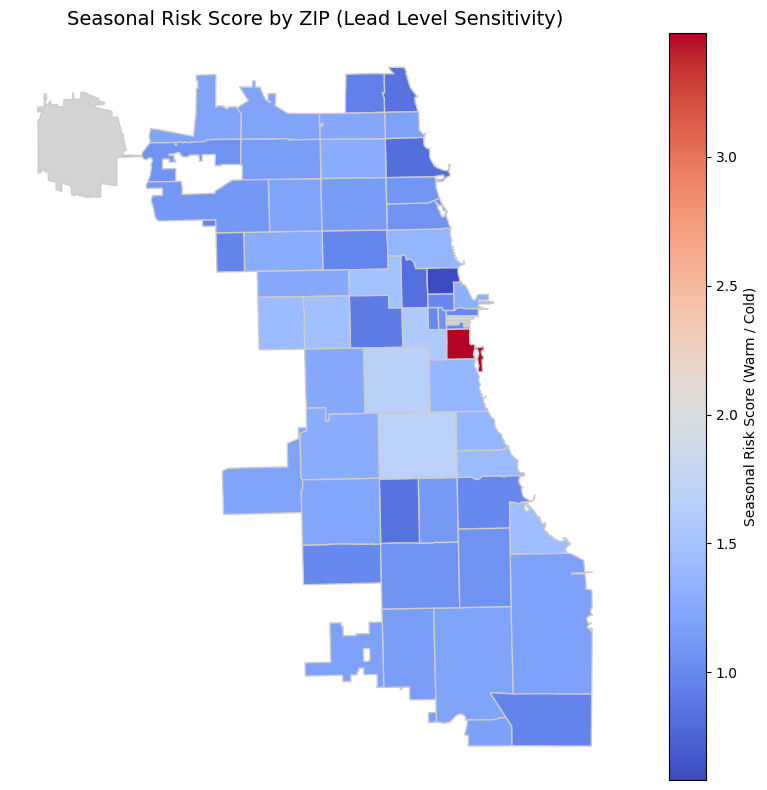

In [14]:
# Merge with GeoDataFrame
gdf_risk = gdf.merge(seasonal_zip, on='ZIP', how='left')

# Plot the Risk Score
fig, ax = plt.subplots(figsize=(10, 8))
gdf_risk.plot(column='RiskScore',
              cmap='coolwarm',
              legend=True,
              edgecolor='0.8',
              ax=ax,
              missing_kwds={"color": "lightgrey", "label": "No data"},
              legend_kwds={"label": "Seasonal Risk Score (Warm / Cold)"})

ax.set_title("Seasonal Risk Score by ZIP (Lead Level Sensitivity)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


## Temperature vs Lead Correlation

Instead of just labeling seasons, we’ll use real temperature data to test:

> “Do higher temperatures actually correlate with higher lead levels?”

### Goal
To test whether **higher outdoor temperatures** are actually associated with **higher lead contamination levels** — going beyond seasonal labels to use real climate data.

---

### What the Code Does
- **Fetches historical monthly temperature data** for Chicago from 2013 to 2024 using the `meteostat` library.
- Extracts the **average monthly temperature** in both °C and °F.
- Merges this with our **existing lead data**, which already has monthly 90th percentile lead levels.
- **Calculates a Spearman correlation** to test the relationship between temperature and lead levels (non-parametric, for safety).
- **Visualizes the correlation** using a scatter plot with a trend line.

---

### Output & Insight
- The correlation coefficient shows a **slight positive trend** — as temperature increases, lead levels tend to rise.
- However, it’s **not strongly statistically significant**, suggesting the effect is weak or noisy.
- This could hint at a real relationship influenced by seasonal pipe corrosion or water chemistry, but more granular data (e.g., weekly or ZIP-level) would help clarify.

In [15]:
!pip install meteostat --quiet

In [16]:
from datetime import datetime
from meteostat import Monthly, Point
import pandas as pd

# Define Chicago as a location
chicago = Point(41.8781, -87.6298)

# Define time range for your data
start = datetime(2013, 1, 1)
end = datetime(2024, 1, 1)

# Get monthly average temperature
data = Monthly(chicago, start, end)
data = data.fetch()

# Keep only the temperature column (in °C)
temp_df = data[['tavg']].reset_index()
temp_df.columns = ['Date', 'AvgTemp_C']
temp_df['year_month'] = temp_df['Date'].dt.to_period('M')

# Convert °C → °F if you want
temp_df['AvgTemp_F'] = temp_df['AvgTemp_C'] * 9/5 + 32

In [17]:
# Your 90th percentile monthly lead data (from earlier)
monthly_df = df.set_index('Sample Date').resample('M')['Max'].quantile(0.9).dropna().reset_index()
monthly_df['year_month'] = monthly_df['Sample Date'].dt.to_period('M')

# Merge with temperature data
merged = pd.merge(monthly_df, temp_df, on='year_month', how='inner')


Spearman Correlation: 0.194, p-value: 0.0565


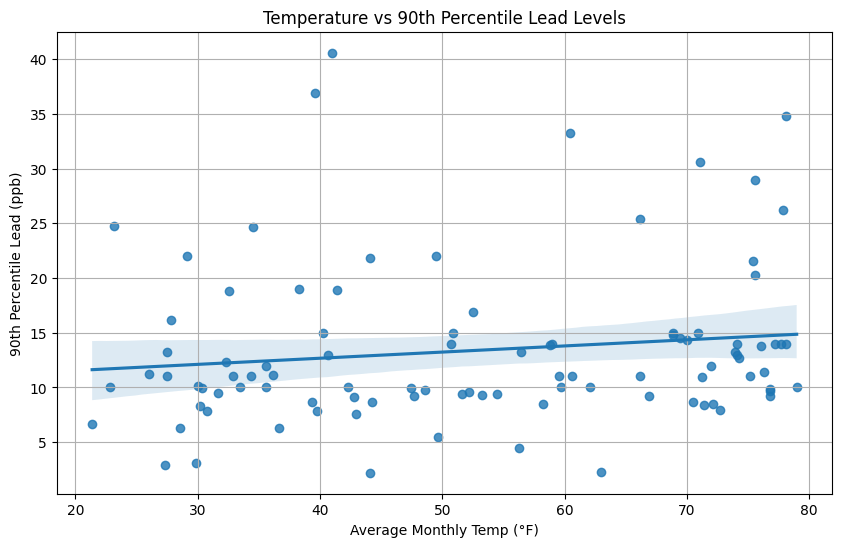

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Spearman correlation
corr, pval = spearmanr(merged['Max'], merged['AvgTemp_F'])

print(f"Spearman Correlation: {corr:.3f}, p-value: {pval:.4f}")

# Scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x='AvgTemp_F', y='Max', data=merged)
plt.title("Temperature vs 90th Percentile Lead Levels")
plt.xlabel("Average Monthly Temp (°F)")
plt.ylabel("90th Percentile Lead (ppb)")
plt.grid(True)
plt.show()


Slight upward trend between temp and lead levels, not quite statistically significant (but borderline)  
Could suggest a weak real-world effect that might strengthen with more data or finer resolution (e.g., weekly)

## Anomaly Detection in Lead Time Series

### Option A: Simple Z-Score Detection

We'll flag anomalies where the 90th percentile lead level is >2 standard deviations above the rolling mean.

### Goal
To automatically detect **unusual spikes** in monthly 90th percentile lead levels using a **rolling statistical method**.

---

### What the Code Does
- Uses a **12-month rolling window** to compute the mean and standard deviation of lead levels over time.
- Calculates a **z-score** for each month: how far it deviates from the rolling mean.
- Flags any month where the z-score is **greater than 2**, indicating a statistically significant anomaly.
- Plots:
  - The original lead level trend
  - The rolling average
  - Anomalies marked in red

---

### Output & Insight
- Highlights **specific months** where lead levels were unusually high relative to recent trends.
- Helps identify **events or environmental shifts** worth investigating (e.g., infrastructure failures or policy changes).



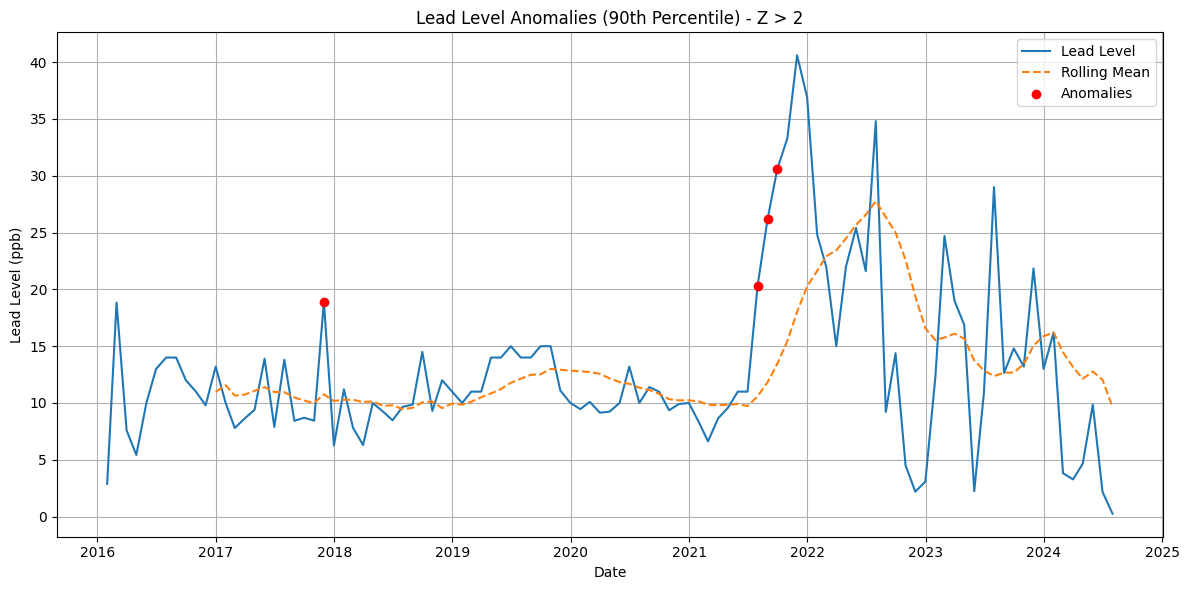

Detected anomaly months:



,Max
Sample Date,
2017-11-30,18.9
2021-07-31,20.3
2021-08-31,26.2
2021-09-30,30.6


In [19]:
# Ensure your monthly 90th data is loaded
lead_series = monthly_df.set_index('Sample Date')['Max']

# Rolling mean & std (12-month window)
rolling_mean = lead_series.rolling(window=12).mean()
rolling_std = lead_series.rolling(window=12).std()

# Z-score
z_scores = (lead_series - rolling_mean) / rolling_std

# Flag anomalies where z > 2
anomalies = lead_series[z_scores > 2]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(lead_series, label='Lead Level')
plt.plot(rolling_mean, label='Rolling Mean', linestyle='--')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies', zorder=5)
plt.title("Lead Level Anomalies (90th Percentile) - Z > 2")
plt.xlabel("Date")
plt.ylabel("Lead Level (ppb)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Detected anomaly months:\n")
display(anomalies)


## Clustering ZIP Codes by Lead Level Trends

### Goal
To group ZIP codes with **similar long-term lead contamination patterns**, helping identify distinct behavioral trends in exposure over time.

---

### What the Code Does

#### Step 1: ZIP x Time Matrix
- Builds a matrix where **each row is a ZIP code**, and each column is a **month**.
- Each cell contains the **90th percentile lead level** for that ZIP-month.
- Missing data is filled using forward and backward fill to smooth gaps.

#### Step 2: Normalize Time Series
- Standardizes each ZIP's lead levels so clustering is based on **trend shape**, not magnitude.
- Ensures fair comparison between ZIPs with different average levels.

#### Step 3: K-Means Clustering
- Applies KMeans (k=4) to the normalized matrix to group ZIPs into clusters based on similar lead patterns.
- Adds the cluster label to each ZIP.

#### Step 4: Map & Analyze Clusters
- Visualizes the clusters on a **ZIP code map of Chicago**.
- Calculates **summary stats** (mean, std, min, max) for each cluster.
- Plots the **average trend over time** for each cluster to compare how they differ.

---

### Output & Insight
- Clusters reveal ZIP codes that behave similarly over time — e.g., some might show consistent drops, others have seasonal peaks.
- Helps prioritize areas for **targeted policies**, **resource allocation**, or **further investigation**.



###  Step 1: Create ZIP x Time Matrix

In [20]:
# Extract year-month for grouping
df['year_month'] = df['Sample Date'].dt.to_period('M')

# Group: ZIP x Month → 90th percentile
zip_month_90th = df.groupby(['ZIP', 'year_month'])['Max'].quantile(0.9).reset_index()

# Pivot to wide format (rows = ZIPs, columns = months)
pivot_df = zip_month_90th.pivot(index='ZIP', columns='year_month', values='Max')

# Fill missing values with forward fill, then backfill
pivot_df = pivot_df.ffill(axis=1).bfill(axis=1)

# Drop ZIPs with too little data (optional)
pivot_df = pivot_df.dropna(thresh=12)  # keep ZIPs with at least 12 valid months

### Step 2: Normalize Each ZIP’s Time Series

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_df)

# Keep original index for mapping back
pivot_scaled_df = pd.DataFrame(pivot_scaled, index=pivot_df.index, columns=pivot_df.columns)


### Step 3: Run Clustering (KMeans for now)

We used KMeans clustering (k=5) to group ZIP codes with **similar patterns in high lead levels over time**. This helps us identify neighborhoods with shared contamination trends, which may reflect underlying infrastructure, water chemistry, or policy conditions.

In [22]:
from sklearn.cluster import KMeans

# Set number of clusters (try 3 to 5)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
pivot_scaled_df['Cluster'] = kmeans.fit_predict(pivot_scaled_df)

# Preview clusters
pivot_scaled_df['Cluster'].value_counts().sort_index()


,count
Cluster,
0,26
1,4
2,1
3,14
4,13


### Step 4: Visualize ZIP Clusters on the Map

The map colors ZIP codes based on their assigned cluster (0 to 4). Each color groups together areas with **similar time series behavior** in their 90th percentile lead levels.


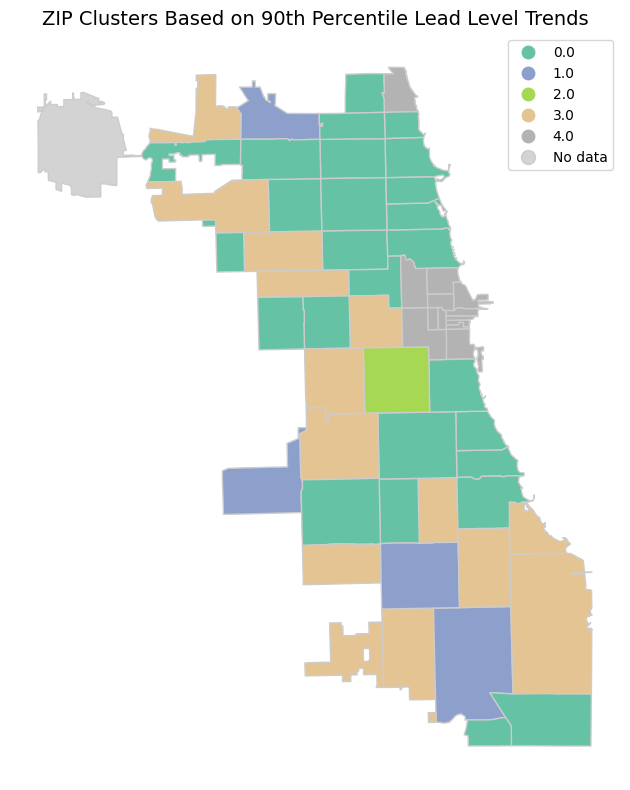

In [23]:
# Merge cluster labels with GeoDataFrame
cluster_map_df = pivot_scaled_df[['Cluster']].reset_index()
gdf_clustered = gdf.merge(cluster_map_df, on='ZIP', how='left')

# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
gdf_clustered.plot(column='Cluster',
                   categorical=True,
                   cmap='Set2',
                   legend=True,
                   edgecolor='0.8',
                   ax=ax,
                   missing_kwds={"color": "lightgrey", "label": "No data"})

ax.set_title("ZIP Clusters Based on 90th Percentile Lead Level Trends", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Add cluster column to your original pivot
pivot_df['Cluster'] = pivot_scaled_df['Cluster']

# Calculate summary stats per cluster
summary = pivot_df.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])
display(summary)


year_month    2016-01                             2016-02                   \
                 mean        std   min     max       mean        std   min   
Cluster                                                                      
0           13.204731  27.818521  0.50  105.70  13.204731  27.818521  0.50   
1           24.030250  21.633696  8.76   55.99  24.030250  21.633696  8.76   
2            7.260000        NaN  7.26    7.26   7.260000        NaN  7.26   
3           15.799357  22.699505  1.54   68.24  15.799357  22.699505  1.54   
4            2.248154   4.512516  0.50   16.70   2.248154   4.512516  0.50   

year_month            2016-03             ... 2024-05            2024-06  \
               max       mean        std  ...     min     max       mean   
Cluster                                   ...                              
0           105.70  11.297154  22.339118  ...    0.25  13.525   2.615962   
1            55.99   3.311500   1.915967  ...    0.25  39.000  15.362500   
2             7.26   0.500000        NaN  ...    4.53   4.530   0.250000   
3            68.24  11.801071  29.905123  ...    1.70  39.000  10.962500   
4            16.70   0.783077   1.020648  ...    0.25  25.070   2.247692   

year_month                             2024-07                           
                  std   min     max       mean        std   min     max  
Cluster                                                                  
0            3.365265  0.25  13.525   2.607308   3.371275  0.25  13.525  
1           16.640081  0.25  39.000  15.362500  16.640081  0.25  39.000  
2                 NaN  0.25   0.250   0.250000        NaN  0.25   0.250  
3            8.421803  0.25  25.610  10.962500   8.421803  0.25  25.610  
4            6.859907  0.25  25.070   2.247692   6.859907  0.25  25.070  

[5 rows x 412 columns]

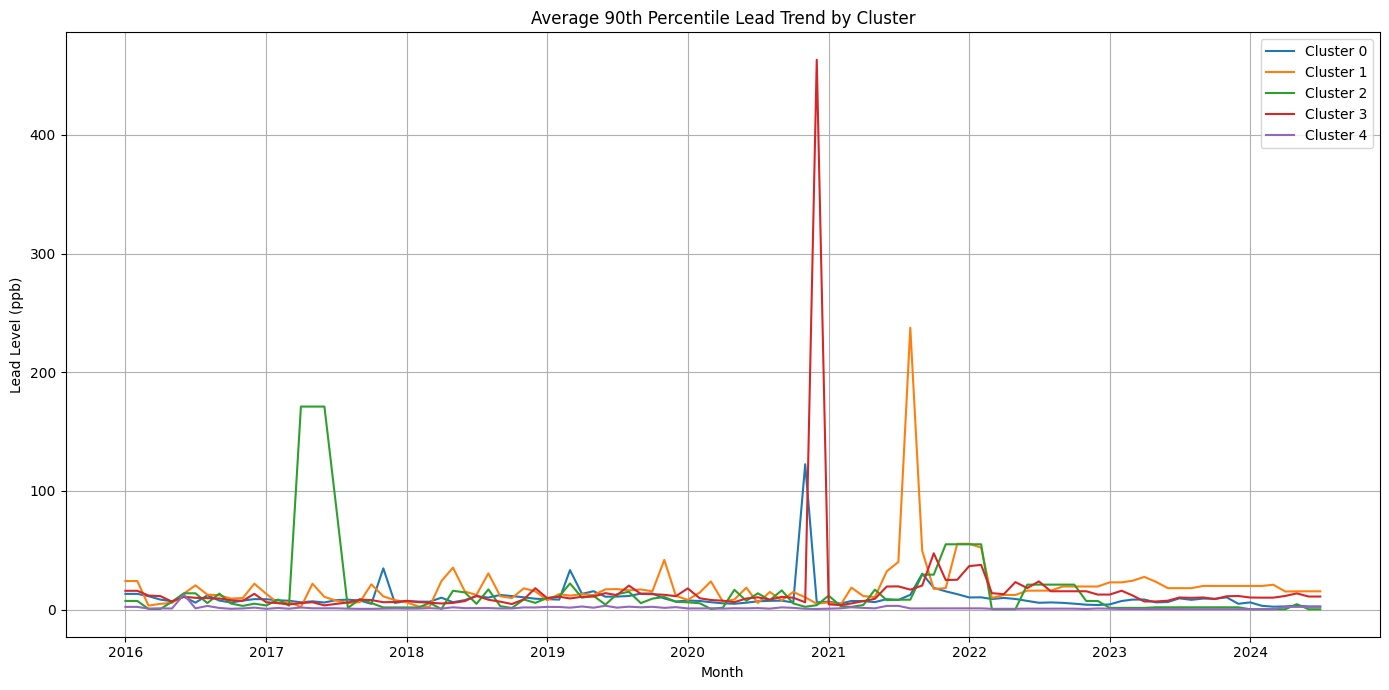

In [25]:
import matplotlib.pyplot as plt

pivot_df_no_cluster = pivot_df.drop(columns='Cluster')
# Convert Period columns to datetime for plotting
pivot_df_no_cluster.columns = pd.PeriodIndex(pivot_df_no_cluster.columns).to_timestamp()



# Transpose so columns = ZIPs, rows = months
cluster_ids = pivot_scaled_df['Cluster']

plt.figure(figsize=(14, 7))
for cluster in sorted(cluster_ids.unique()):
    cluster_zips = cluster_ids[cluster_ids == cluster].index
    cluster_trend = pivot_df_no_cluster.loc[cluster_zips].mean()
    plt.plot(cluster_trend, label=f'Cluster {cluster}')

plt.legend()
plt.title('Average 90th Percentile Lead Trend by Cluster')
plt.xlabel('Month')
plt.ylabel('Lead Level (ppb)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Cluster Profile Insights

### Goal
To analyze how each cluster behaves over time in terms of:
- **Average lead level trends**
- **Volatility (standard deviation) of lead levels**

---

### Average Trend by Cluster
- Extracts the **mean lead level per month** for each cluster.
- Plots each cluster’s **average 90th percentile lead level** across time.

**What it shows:**
- Some clusters may have **persistently high values**, while others show **declines or seasonality**.
- Helps identify which groups are improving, stable, or worsening.

---

### Volatility (Standard Deviation)
- Plots the **month-to-month variability** of lead levels for each cluster.
- High volatility indicates **inconsistent risk** or **sensitivity to external factors** (e.g., temperature, pipe condition).

**What it shows:**
- Clusters with **high standard deviation** are less predictable and may require more frequent monitoring.
- **Low-volatility clusters** are either consistently safe or consistently hazardous.

---

### Why This Matters
These profiles help define **risk types**:
- **High mean, high volatility** → urgent and unstable areas
- **High mean, low volatility** → chronic risk zones
- **Low mean, high volatility** → unpredictable hotspots
- **Low mean, low volatility** → consistently safe ZIPs

This enables **customized intervention strategies** based on both severity and stability.

### Step 1: Plot Average Trend by Cluster

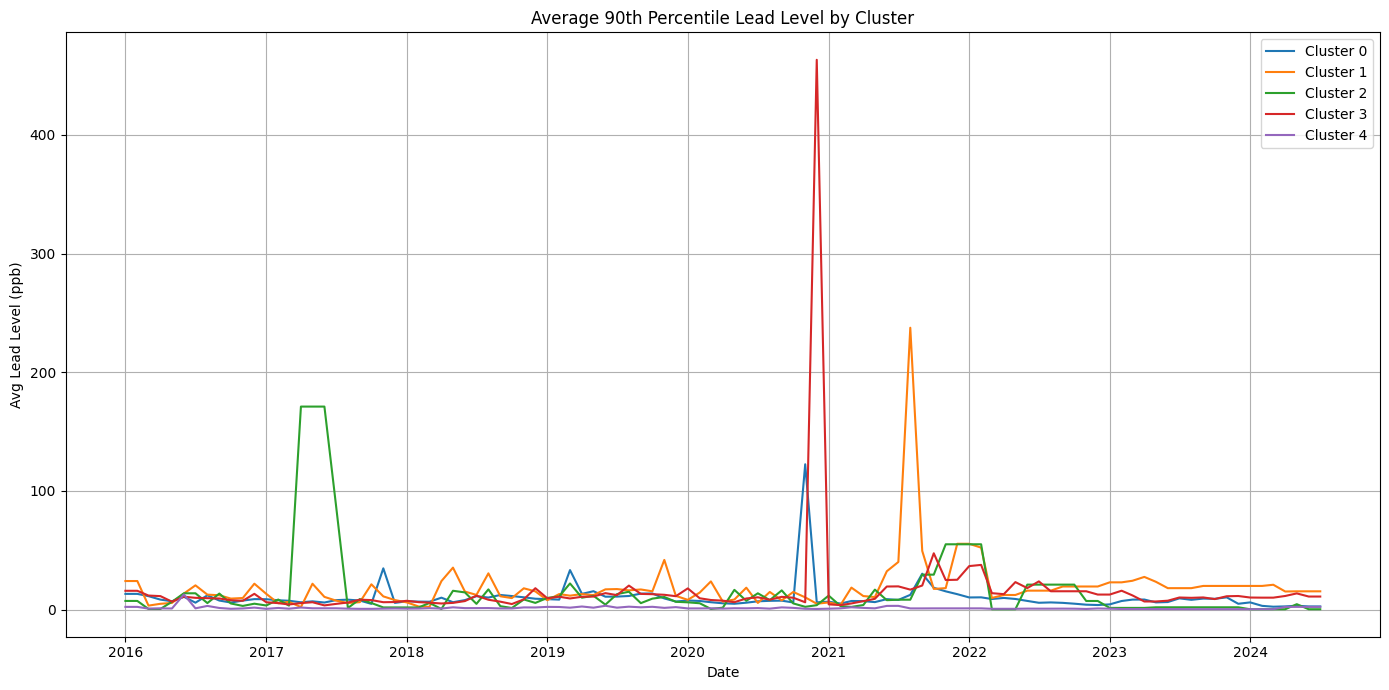

In [26]:
# Get just the mean values from your cluster summary table
cluster_means = summary.xs('mean', axis=1, level=1)  # Pull only 'mean' from MultiIndex

# Convert columns to datetime (just like before)
cluster_means.columns = pd.PeriodIndex(cluster_means.columns).to_timestamp()

# Plot each cluster's average lead trend
plt.figure(figsize=(14, 7))
for i in cluster_means.index:
    plt.plot(cluster_means.columns, cluster_means.loc[i], label=f'Cluster {i}')

plt.title("Average 90th Percentile Lead Level by Cluster")
plt.xlabel("Date")
plt.ylabel("Avg Lead Level (ppb)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Volatility Comparison (Standard Deviation)

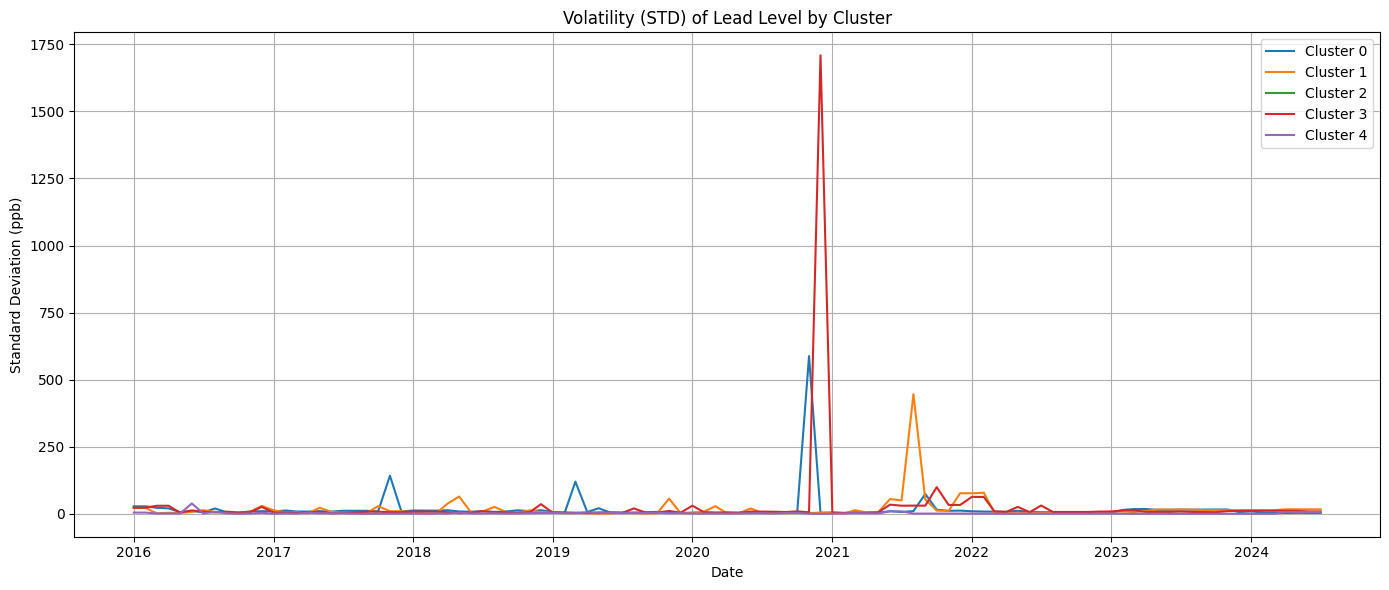

In [27]:
# Pull standard deviation data
cluster_std = summary.xs('std', axis=1, level=1)
cluster_std.columns = pd.PeriodIndex(cluster_std.columns).to_timestamp()

# Plot std trend per cluster
plt.figure(figsize=(14, 6))
for i in cluster_std.index:
    plt.plot(cluster_std.columns, cluster_std.loc[i], label=f'Cluster {i}')

plt.title("Volatility (STD) of Lead Level by Cluster")
plt.xlabel("Date")
plt.ylabel("Standard Deviation (ppb)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Link Clusters to Pipe Material & Building Age

### Goal
To understand whether **high-risk lead clusters** are associated with:
- Specific **pipe materials**
- **Older buildings**

This helps support targeted intervention strategies like:
> “Focus on buildings with unknown or galvanized pipes in high-risk clusters.”

---

### What the Code Does

#### Step 1: Merge Cluster Labels
- Adds the **cluster label** to each water test record by merging ZIP-level clusters back into the full dataset.

#### Step 2: Pipe Material Analysis
- Groups the data by **pipe wall material** and **cluster**, then computes:
  - Sample count
  - Mean lead level
  - Median lead level
- Outputs the **top materials** contributing to high average lead levels within clusters.

#### Step 3: Building Age Comparison
- Plots a **boxplot of building age** for each cluster.
- Lets us visually compare the **distribution of building ages** across risk groups.

---

### Insight
- Certain **materials (e.g., galvanized or unknown)** may appear more often in high-lead clusters.
- High-risk clusters may skew toward **older buildings**, supporting the case for age-targeted policies.
- This linkage strengthens the **evidence base for mitigation priorities** — retrofitting or inspecting older buildings with risky infrastructure in the worst-hit clusters.


> Understand whether certain materials or older buildings are more common in high-risk clusters

> Support policy decisions like “Target old buildings with unknown materials in Cluster 1”

### Step 1: Merge Cluster Labels Back to Original Data

In [28]:
# Ensure you have cluster labels on ZIPs
zip_cluster_map = pivot_scaled_df[['Cluster']].reset_index()  # columns: ZIP, Cluster

# Merge into main DataFrame
df_clustered = df.merge(zip_cluster_map, on='ZIP', how='left')


### Step 2: Analyze by Pipe Material

In [29]:
# Group by pipe material and cluster
pipe_stats = df_clustered.groupby(['Wall Material', 'Cluster'])['Max'].agg(['count', 'mean', 'median']).reset_index()

# Top pipe materials per cluster
top_pipes = pipe_stats.sort_values(by='mean', ascending=False).dropna()
display(top_pipes.head(10))

,Wall Material,Cluster,count,mean,median
13,3.0,3,784,19.585982,4.55
1,1.0,1,680,15.417529,4.80
11,3.0,1,289,10.724983,5.80
6,2.0,1,1750,9.550446,5.10
3,1.0,3,1580,7.742171,4.00
8,2.0,3,4069,7.592475,4.50
16,4.0,1,16,7.293750,4.85
5,2.0,0,6400,7.078813,2.70
18,4.0,3,111,6.554775,4.10
0,1.0,0,3459,6.101090,3.00


### Step 3: Analyze Building Age by Cluster

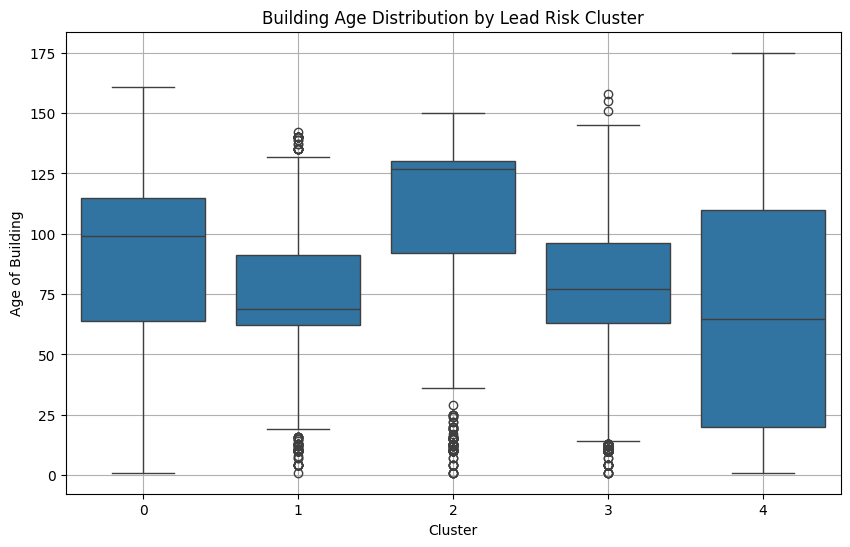

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clustered, x='Cluster', y='Age')
plt.title("Building Age Distribution by Lead Risk Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age of Building")
plt.grid(True)
plt.show()


## Spatial Mapping of Summary Metrics (mean, max)

### Goal
To visualize **average** and **worst-case** lead contamination across Chicago ZIP codes using spatial maps.

---

### What the Code Does

#### Step 1: Compute Summary Stats by ZIP
- Groups water test data by ZIP code.
- Calculates the **mean** and **maximum** of the 90th percentile lead levels for each ZIP.

#### Step 2: Merge and Plot
- Merges summary stats with Chicago ZIP code shapefile.
- Creates two choropleth maps:
  - One for **mean lead levels** — shows general contamination exposure.
  - One for **maximum lead levels** — highlights extreme hotspots.

---

### Insight
- Mean maps show **broad exposure patterns** across neighborhoods.
- Max maps reveal **ZIPs with record-breaking spikes** that could indicate localized infrastructure issues.
- Together, these maps help prioritize both **widespread risk** and **emergency-level outliers**.


### Step 1: Compute Mean & Max by ZIP

In [31]:
zip_summary = df.groupby('ZIP')['Max'].agg(['mean', 'max']).reset_index()
zip_summary.columns = ['ZIP', 'Mean_Lead', 'Max_Lead']


### Step 2: Merge with Geodata and Plot

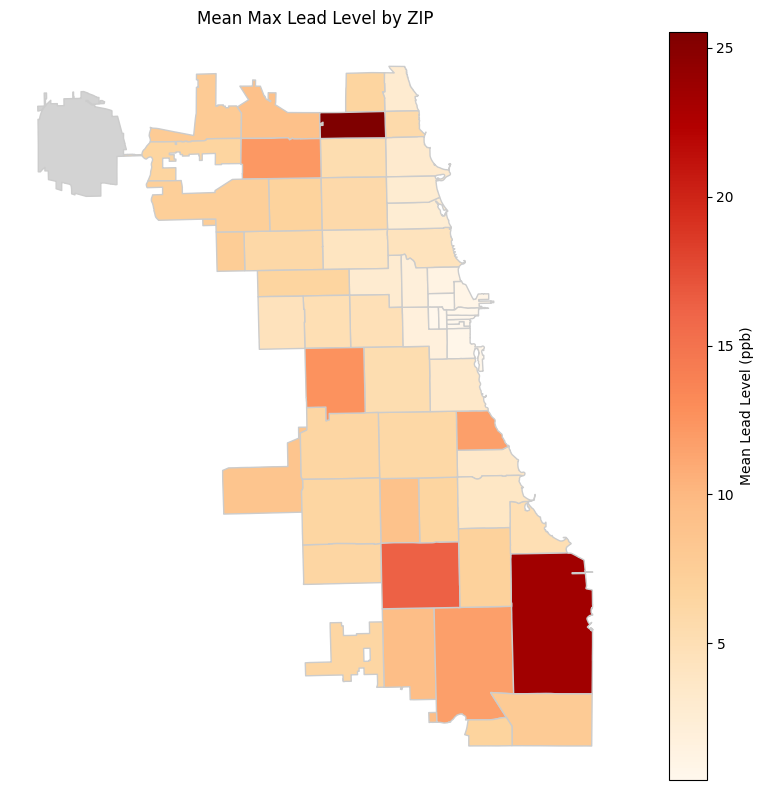

In [32]:
# Merge with ZIP shapefile
gdf_lead_stats = gdf.merge(zip_summary, on='ZIP', how='left')

# Plot: Mean Lead Levels
fig, ax = plt.subplots(figsize=(10, 8))
gdf_lead_stats.plot(column='Mean_Lead',
                    cmap='OrRd',
                    legend=True,
                    edgecolor='0.8',
                    ax=ax,
                    missing_kwds={"color": "lightgrey", "label": "No data"},
                    legend_kwds={"label": "Mean Lead Level (ppb)"})

ax.set_title("Mean Max Lead Level by ZIP")
ax.axis('off')
plt.tight_layout()
plt.show()

# Same for Max_Lead — just swap the column name


## Build a Risk Score Per ZIP Code

### Goal
To combine multiple factors into a **single lead risk score** for each ZIP code, helping identify neighborhoods most in need of intervention.

---

### What the Code Does

#### Step 1: Prepare Risk Components
Combines the following metrics per ZIP:
- **Mean lead level** (overall exposure)
- **Max lead level** (worst-case scenario)
- **Trend direction** (how lead levels have changed over time)
- **Seasonal spike sensitivity** (how much levels increase in warmer months)

Each component provides a unique view of risk — combining them offers a more complete picture.

#### Step 2: Normalize and Compute Final Score
- All components are scaled between 0 and 1 using MinMax normalization.
- The final risk score is computed as the **average of all normalized components** (equal weights by default).
- ZIP codes are ranked by this final score.

#### Step 3: Visualize the Risk Score
- The score is mapped across Chicago ZIP codes using a red-yellow scale:
  - **Darker red** = higher composite risk.
  - **Gray** = missing data.

---

### Insight
This score enables:
- **Data-driven targeting** of ZIPs with combined lead risks.
- **Prioritization** of neighborhoods for pipe replacements, inspections, or public health outreach.
- A scalable, transparent way to integrate new factors (e.g., pipe material risk) in future versions.


Create a composite lead risk score that blends:

> Average lead level

> Max observed value

> Trend direction

> Seasonal spike sensitivity

> (Optional) Pipe age or material risk

Then visualize it across Chicago to highlight ZIPs most in need of intervention.

### Step 1: Prepare Components for Risk Score

In [33]:
# Use the existing summaries
zip_risk_df = df.groupby('ZIP')['Max'].agg(['mean', 'max']).reset_index()
zip_risk_df.columns = ['ZIP', 'Mean_Lead', 'Max_Lead']

# Add trend direction: difference between last and first month (normalized)
trend_by_zip = pivot_df.apply(lambda row: row.iloc[-1] - row.iloc[0], axis=1).reset_index()
trend_by_zip.columns = ['ZIP', 'Trend_Direction']

# Add seasonal sensitivity score from earlier
# Assume seasonal_zip already exists from Step 2
seasonal_score = seasonal_zip[['RiskScore']].reset_index()

# Merge all components
zip_risk_all = zip_risk_df.merge(trend_by_zip, on='ZIP', how='left') \
                          .merge(seasonal_score, on='ZIP', how='left')


### Step 2: Normalize Components & Compute Final *Score*

In [34]:
from sklearn.preprocessing import MinMaxScaler

features = ['Mean_Lead', 'Max_Lead', 'Trend_Direction', 'RiskScore']
scaler = MinMaxScaler()
zip_risk_all_scaled = zip_risk_all.copy()
zip_risk_all_scaled[features] = scaler.fit_transform(zip_risk_all[features])

# Create final risk score (equal weight, or you can change weights)
zip_risk_all_scaled['FinalRiskScore'] = zip_risk_all_scaled[features].mean(axis=1)

# Sort by risk score
zip_risk_all_scaled = zip_risk_all_scaled.sort_values(by='FinalRiskScore', ascending=False)


### Step 3: Map the Risk Score Across ZIP Codes

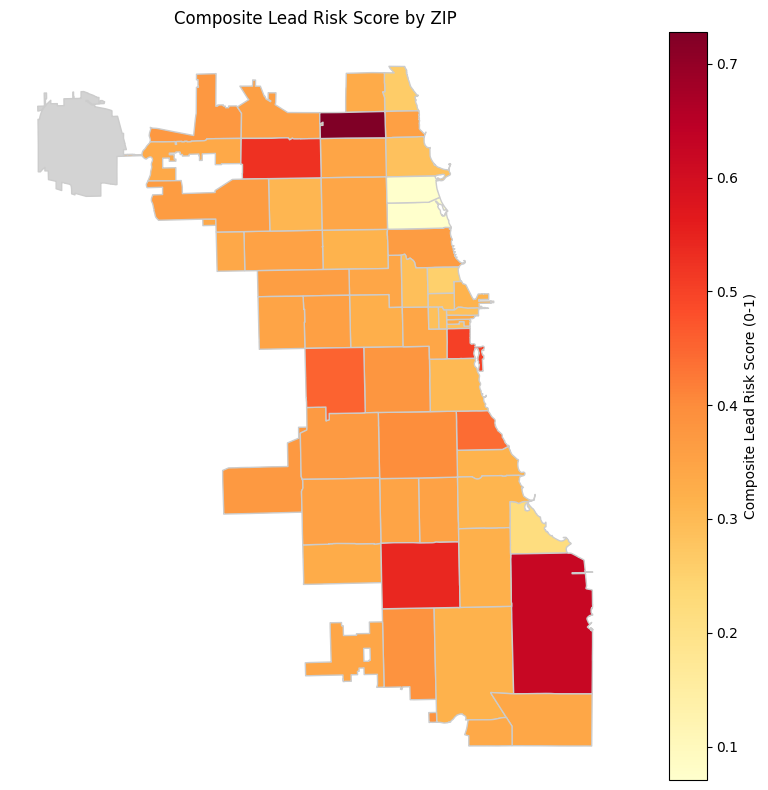

In [35]:
# Merge with GeoDataFrame
gdf_riskmap = gdf.merge(zip_risk_all_scaled, on='ZIP', how='left')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf_riskmap.plot(column='FinalRiskScore',
                 cmap='YlOrRd',
                 legend=True,
                 edgecolor='0.8',
                 ax=ax,
                 missing_kwds={"color": "lightgrey", "label": "No data"},
                 legend_kwds={"label": "Composite Lead Risk Score (0-1)"})

ax.set_title("Composite Lead Risk Score by ZIP")
ax.axis('off')
plt.tight_layout()
plt.show()